In [10]:
from numpy import zeros, max, abs, reshape
from scipy.sparse.linalg import factorized
from scipy.sparse import eye

class MGDirect:
    def __init__(self,A):
        self.solve = factorized(A.tocsc())
    def __call__(self,x,b):
        b1d = reshape(b,-1)
        x = self.solve(b1d)
        return reshape(x,b.shape)
class MGJacobi:
    def __init__(self,A,ncycle= 4, niter= 10, subsolver=None):
        self.A = A
        self.ncycle = ncycle
        self.niter = niter
        self.diag = A.diagonal()
        self.subsolver = subsolver
        self.sub_b = None
        self.xupdate = None
        def __call__(self,xi,bi,ncycle=None,niter=None):
            x = reshape(xi,-1)
            b = reshape(bi,-1)
            if ncycle is None:
                ncycle = self.ncycle
            if niter is None:
                niter = self.niter
            for c in range(ncycle):
                for i in range(niter):
                    x += (b-self.A.dot(x))/self.diag
                    if self.subsolver:
                        error = b-self.A.dot(x)
                        self.sub_b = restrict(reshape(error,xi.shape))
                        sub_x = zeros(self.sub_b.shape)
                        sub_x = self.subsolver(sub_x,self.sub_b)
                        self.xupdate = interpolate(sub_x)
                        x += reshape(self.xupdate,-1)
                    for i in range(niter):
                        x += reshape(b-self.A.dot(x))/self.diag
                return x.reshape(xi.shape)
def restrict(orig,out=None,avg=False):
    nx = orig.shape[0]
    ny = orig.shape[1]
    if (nx-1)%2 == 1 or (ny-1)%2 ==1:
        if out is None:
            return orig
        out.resize(orig.shape)
        out[:,:] = orig
        return 
    nx = (nx-1)//2 +1
    ny = (ny-1)//2 +1
    if out is None:
        out = zeros([nx,ny])
    else:
        out.resize([nx,ny])
    for x in range(1,nx-1):
        for y in range(1,ny-1):
            x0 = 2*x
            y0 = 2*y
            out[x,y] = orig[x0,y0]/4.0
            +(
                orig[x0+1,y0]
                + orig[x0-1,y0]
                + orig[x0,y0+1]
                +orig[x0,y0-1]
            )/8.0
            +(
                orig[x0-1,y0-1]
                + orig[x0-1,y0+1]
                + orig[x0+1,y0-1]
                + orig[x0+1,y0+1]
            )/16.0
    if not avg:
        out *=4.0
    return out
    

In [5]:
def Interpolate(orig,out=None):
    nx = orig.shape[0]
    ny = orig.shape[1]
    nx2 = 2*(nx - 1) + 1
    ny2 = 2*(ny - 1) + 1
    if out is None:
        out = zeros([nx2,ny2])
    else:
        out[:,:] = 0.0
    for x in range(1,nx-1):
        for y in range(1,ny-1):
            x0 = 2*x
            y0 = 2*y
            out[x0-1,y0-1] += 0.25*orig[x,y]
            out[x0-1,y0] += 0.5*orig[x,y]
            out[x0-1,y0+1] += 0.25*origin[x,y]
            out[x0,y0-1] += 0.5*orig[x,y]
            out[x0,y0] = orig[x,y]
            out[x0,y0+1] += 0.5*orig[x,y]
            out[x0+1,y0-1] += 0.25*orig[x,y]
            out[x0+1,y0] += 0.5*orig[x,y]
            out[x0+1,y0+1] += 0.25*origin[x,y]
    return out


In [6]:
class MGJacobi:
    def __init__(self, level, subsolver=None):
        self.level = level
        self.subsolver = subsolver

    def __call__(self, x, b):
        print(f"Level {self.level}: Starting solver...")

        # Fake Jacobi smoothing step
        print(f"Level {self.level}: Performing Jacobi smoothing...")

        if self.subsolver:
            print(f"Level {self.level}: Calculating error and restricting to coarser level...")

            # Recursive call to coarser level
            x_correction = self.subsolver(x, b)

            print(f"Level {self.level}: Interpolating correction back from level {self.level+1}...")
            print(f"Level {self.level}: Applying correction from coarser level.")

        else:
            print(f"Level {self.level}: No subsolver, stopping recursion.")

        print(f"Level {self.level}: Final Jacobi smoothing...\n")
        return x


In [7]:
# Coarsest solver — no subsolver
solver_lvl2 = MGJacobi(level=2)

# Mid-level solver — uses lvl2 as subsolver
solver_lvl1 = MGJacobi(level=1, subsolver=solver_lvl2)

# Finest level solver — uses lvl1 as subsolver
solver_lvl0 = MGJacobi(level=0, subsolver=solver_lvl1)


In [8]:
# Just use dummy x and b since we’re only printing
x = [0]
b = [1]

solver_lvl0(x, b)


Level 0: Starting solver...
Level 0: Performing Jacobi smoothing...
Level 0: Calculating error and restricting to coarser level...
Level 1: Starting solver...
Level 1: Performing Jacobi smoothing...
Level 1: Calculating error and restricting to coarser level...
Level 2: Starting solver...
Level 2: Performing Jacobi smoothing...
Level 2: No subsolver, stopping recursion.
Level 2: Final Jacobi smoothing...

Level 1: Interpolating correction back from level 2...
Level 1: Applying correction from coarser level.
Level 1: Final Jacobi smoothing...

Level 0: Interpolating correction back from level 1...
Level 0: Applying correction from coarser level.
Level 0: Final Jacobi smoothing...



[0]

In [ ]:
def createVcycle(nx,ny,generator,nlevels=4,ncycle=1,niter=10,direct=True):
    if (nx-1)%2 == 1 or (ny-1)%2 == 1:
        nlevels = 1
    if nlevels>1:
        nxsub = (nx-1)//2 +1
        nysub = (nysub-1)//2 +1
        subsolver = createVcycle(nxsub,nysub,generator, nlevels-1,niter=niter,direct=direct)
        A = generator(nx,ny)
        return MGJacobi(A,niter=niter,ncycle = ncycle,subsolver = None)
    A = generator(nx,ny)
    if direct:
        return MGDirect(A)
    return MGJacobi(A,niter=niter,ncycle=ncycle,subsolver=None)

In [13]:
def smoothJacobi(A,x,b,dx,dy):
    if b.shape != x.shape:
        raise ValueError("b and x have different shapes")
    smooth = x + (b-A(x,dx,dy))/A.diag(dx,dy)
    return smooth
def smoothVcycle(A,x,b,dx,dy,niter=10,sublevels = 0,direct=True):
    for i in range(niter):
        x = smoothJacobi(A,x,b,dx,dy)
    if sublevels>0:
        error = b-A(x,dx,dy)
        cerror = restrict(error)
        cx = zeros(cerror.shape)
        cx = smoothVcycle(A,cx,cerror,dx*2.0,dy*2.0,niter,sublevels-1)
        xupdate = interpolate(cx)
        x = x + xupdate
    for i in range(niter):
        x = smoothJacobi(A,x,b,dx,dy)
    return x

def smoothMG(A,x,b,dx,dy,niter=10,sublevels = 1,ncycle = 2):
    error = b - A(x,dx,dy)
    print("Starting max residual: %e "%(max(abs(error)),))
    for c in range(ncycle):
        x = smoothVcycle(A,x,b,dx,dy,niter,sublevels)
        error = b - A(x,dx,dy)
        print(
            "Cycle %d : %e"
            %(
                c,
                max(abs(error))
            )
        )
    return x
        

In [24]:
class LaplacianOp:
    def __call__(self,f,dx,dy):
        nx = f.shape[0]
        ny = f.shape[1]
        b = zeros([nx,ny])
        for x in range(1,nx-1):
            for y in range(1,ny-1):
                b[x,y] = (f[x-1,y] - 2 * f[x,y] +f[x+1,y])/dx**2 + (f[x,y-1] - 2 * f[x,y] + f[x,y+1])/dy**2
        return b
    def diag(self,dx,dy):
        return -2.0/dx**2 - 2.0/dy**2
    

In [25]:
class LaplaceSparse:
    def __init__(self,Lx,Ly):
        self.Lx = Lx
        self.Ly = Ly
        def __call__(self,nx,ny):
            dx = self.Lx / (nx - 1)
            dy = self.Ly / (ny - 1)
            N = nx * ny
            A = eye(N,format="lil")
            for x in range(1,nx-1):
                for y in range(1,ny-1):
                    row = x * ny + y
                    A[row,row] = - 2.0/dx**2 - 2.0/dy**2
                    A[row,row-1] = 1.0/dy**2
                    A[row,row+1] = 1.0/dy**2
                    A[row,row-ny] = 1.0/dx**2
                    A[row,row+ny] = 1.0/dx**2
            return A.tocsr()

0 9.984753e-01


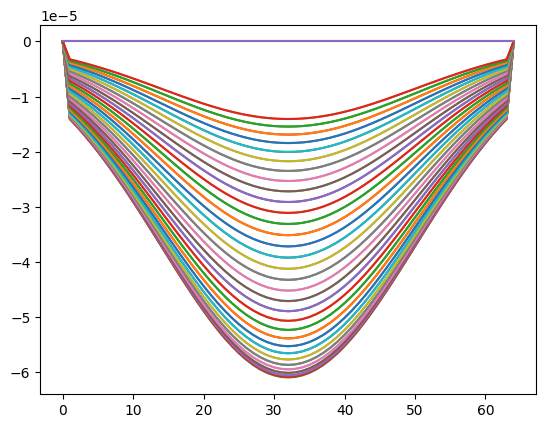

<Figure size 640x480 with 0 Axes>

In [31]:
if __name__ == "__main__":
    from numpy import meshgrid,exp,linspace
    import matplotlib.pyplot as plt
    from timeit import default_timer as timer
    nx = 65
    ny = 65
    dx = 1.0/(nx-1)
    dy = 1.0/(ny-1)
    xx , yy = meshgrid(linspace(0,1,nx),linspace(0,1,ny))
    rhs = exp(-((xx - 0.5)**2 + (yy - 0.5)**2)/0.4**2)
    rhs[0,:] = 0.0
    rhs[:,0] = 0.0
    rhs[nx - 1,:] = 0.0
    rhs[:,ny-1] = 0.0 
    x = zeros([nx,ny])
    x2 = x.copy()
    A = LaplacianOp()
    ##########################SIMPLE ITERATIVE SOLVER####################################
    for i in range(1):
        x2 = smoothJacobi(A,x,rhs,dx,dy)
        x,x2 = x2,x
        error = rhs - A(x,dx,dy)
        print("%d %e"%(i,max(abs(error))))
    plt.plot(x)
    plt.show()
    plt.savefig("error.png")